# SkmiLit NLP Project

The purpose of this noebook is to build an NLP model to make reading medical abstracts easier. We will replicate the *PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts*

The paper is available <a href="https://arxiv.org/abs/1710.06071">here</a>

The model they've used to achieve their best results is <a href="https://arxiv.org/pdf/1612.05251.pdf">here</a>


To recreate the model I've drawn inspiration from daniel bourke's github library <a href="https://github.com/mrdbourke/tensorflow-deep-learning/">here</a> 

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b6f03dee-89c5-93fa-ba54-6131fe4514b3)


## Get Data

Since we'll be replicating the paper above (PubMed 200K RCT), we'll download the dataset they used through the author's github <a href="https://github.com/Franck-Dernoncourt/pubmed-rct">here</a>

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


`dev.txt` means nothing more than a validation set. Rest are self-explanatory.

We shall now get the data in directories and save the filenames of the `.txt` files. For the purpose of our project, we shall use the `PubMed_20K_RCT_numbers_replaced_with_at_sign` version rather than the full 200k dataseta as we lack the computing power to use it.

In [5]:
#Save the path directory.
dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/" 

# check the available .txt files in path directory and save them  
import os
filenames = [dir + i for i in os.listdir(dir)]
filenames 

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess Data

Now that we have our text data with us, it's time to preprocess it and visualize it before creating the model

In [6]:
# Let us create a function to get all the lines in our text directory
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
# Now we will read in the first 30 training lines
train_lines = get_lines(dir + "train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
# let us now check the total number of training lines
len(train_lines)

210040

Our data should ideally be represented in this dictionary format to make our work easier

```
[{"line_number" : 0,
  "target" : "BACKGROUND".
  "text" : "Emotional eating is associated with overeating and the development of obesity .\n'",
  "total_lines" : 11}, ...{}]
```

In order to do that ,we shall now create a function to preprocess the lines for our benefit by segregating them on a target, line number, total lines and text basis

In [11]:
def preprocess_text(filename):

  # get all lines from target file
  input_lines = get_lines(filename) 
  abstract_lines = "" 
  abstract_samples = [] 
  
  # Visit every line in the received lines input
  for line in input_lines:
    # Check if it is an ID line begginging with ###
    if line.startswith("###"): 
      abstract_id = line
      abstract_lines = ""
    # check if it is a new line
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() 
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        # Since it indeed is a new line we shall now place the data in a disctionary and then later insert it in the list
        line_data = {} 
        target_text_split = abstract_line.split("\t") 
        line_data["target"] = target_text_split[0] 
        line_data["text"] = target_text_split[1].lower() 
        line_data["line_number"] = abstract_line_number 
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) 
    # if none of the above conditions are satisfied then its supposed to continue counting.
    else:
      abstract_lines += line
  
  return abstract_samples


In [14]:
# Get data from .txt files and preprocess it to turn it into list of dictionary format
train_samples = preprocess_text(dir + "train.txt")
val_samples = preprocess_text(dir + "dev.txt")
test_samples = preprocess_text(dir + "test.txt")

# check the length of each list of dictionaries
len(train_samples) , len(val_samples) , len(test_samples)

(180040, 30212, 30135)

Now that our data is the format of a list of dictionaries, we will turn it into a DataFrame to visualize better

In [15]:
# import pandas library
import pandas as pd
# create pandas dataframe
train_df, val_df , test_df = pd.DataFrame(train_samples), pd.DataFrame(val_samples),  pd.DataFrame(test_samples)

train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


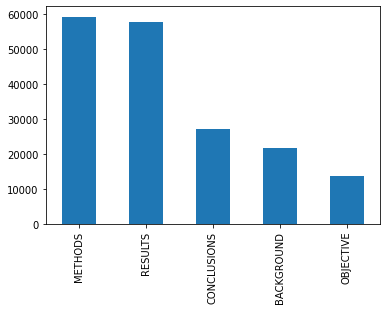

In [16]:
# Check out label distribution
train_df.target.value_counts().plot(kind = "bar")

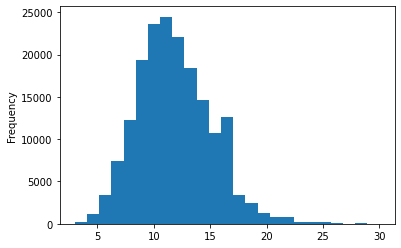

In [18]:
# check out line frequency distributions
train_df.total_lines.plot(kind = "hist" , bins = 25)

### Get a list of sentences

In [19]:
# Convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

len(train_sentences) , len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
# View the first 20 lines of our training sentences
train_sentences[:20]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

ML models requires data, therefore it is necessary to bring labels to numerical value for any model to work.

We shall one-hot-encode or label-encode it upto our requirements.

In [23]:
# Import onehotencoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# one hot encode the target labels
one_hot_encoder = OneHotEncoder(sparse=False)
# Note: By using the sparse = False we are going to save memory in cases of arrays with most labels set = 0
# This will help increase our computation speed

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Encode Labels

In [24]:
# Import labelencoder from sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# use the label encoder and fit it on our labels
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded =  label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
# get class names from label encoder transformation
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

## Creating a series of model experiments

We've proprocessed our data so now, in true machine learning fashion, it's time to setup a series of modelling experiments.

We'll start by creating a simple baseline model to obtain a score we'll try to beat by building more and more complex models as we move towards replicating the sequence model outlined in <a href="https://arxiv.org/pdf/1612.05251.pdf">Neural networks for joint sentence classification in medical paper abstracts.</a>

For each model, we'll train it on the training data and evaluate it on the validation data.

## Model 0: Getting a baseline

We will use the TF-IDF vectorizer layer in this model with the Multinomial Naive Bayes algorithm which trains very quickly

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# creating pipelines
model_0 = Pipeline([
                    ("tf-idf", TfidfVectorizer()),
                    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,
            train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# evaluate baseline model on val_dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [28]:
# making predictions with our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Evaluating our functions
Let us now create function to help us evaluate our predictions over a series of metrics

In [29]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [30]:
# calculate baseline_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing the text into numeric format for deep sequence models

Before we start building deep learning models, we've gotta create vectorization and embedding layers on our own rather than rely on sklearn.

In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers


In [32]:
# Calculate average sentence length and the total sentences
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

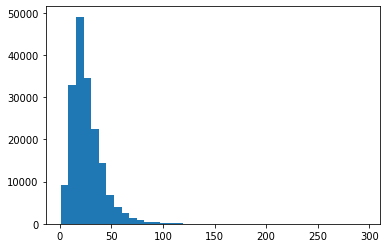

In [33]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins = 40);

In [34]:
# at what length of sentence does 95% senteces get covered?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [35]:
# What is the maximum sentence training length (note: this will be used for padding)
max(sent_lens)  

296

### Creating text vectorization layers

We will now tokenize our layer in order to allow our deep learning model to function.

We'll keep all the parameters default except for `max_tokens` (the number of unique words in our dataset) and `output_sequence_length` (our desired output length for each vectorized sentence)

>from table 3.2 in https://arxiv.org/pdf/1710.06071.pdf , it can be noted that the total number of words in our vocabulary our 68,000 so we will save them in a `max_tokens` variable


In [37]:
max_tokens = 68000

In [38]:
# Creating text vectorization layer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens, # number of vocab words
                                    output_sequence_length = output_seq_len) # max output seq length

In [39]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [40]:
# We should be able to map our text_vectorizer to random sentences
import random
ts = random.choice(train_sentences)
print(f"Text:\n{ts}")
print(f"\nLength of text: {len(ts)}")
print(f"\nVectorizes text: {text_vectorizer([ts])}")

Text:
in each period , subjects received @ mg enoxaparin ( in part @ ) , @,@ units ufh ( in part @ ) , or placebo followed by @ or @ mg/kg sugammadex , or placebo .

Length of text: 158

Vectorizes text: [[   5  122  173  104   80   68 5217    5  732  937 6329    5  732   16
    48  284   22   16  618 3866   16   48    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [41]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [42]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [43]:
tf.random.set_seed(42)

token_embed = tf.keras.layers.Embedding(
    input_dim = len(rct_20k_text_vocab),
    output_dim = 128,
    mask_zero = True,
    name = "token_embedding"
)

In [44]:
# Show example embedding
print(f"Sentence before vectorization:\n{ts}\n")
vectorized_sentence = text_vectorizer([ts])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
in each period , subjects received @ mg enoxaparin ( in part @ ) , @,@ units ufh ( in part @ ) , or placebo followed by @ or @ mg/kg sugammadex , or placebo .

Sentence after vectorization (before embedding):
[[   5  122  173  104   80   68 5217    5  732  937 6329    5  732   16
    48  284   22   16  618 3866   16   48    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.03521683 -0.00981399 -0.00284491 ... -0.04792733 -0.01664252
   -0.03293632]
  [-0.0216957   0.03589905 -0.02001362 ... -0.03543859  0.00250389
    0.0052032 ]
  [ 0.0493855   0.04483533 -0.04828952 ... -0.02406688 -0.02627992
   -0.03924746]
  ...
  [ 0.01645621 -0.00589932 -0.01471175 ... -0.02511839  0.00912381
   -0.00024097]
  [ 0.01645621 -0.00589932 -0.01471175 ... -0.02511839  0.00912381
   -0.00024097]
  [ 0.01645621 -0.00589932 

## Creating datasets

Making sure our data works as fast as possible.

We're going to setup our data to fast with the TensorFlow `tf.data API`.

The many steps are discussed in these resources
* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/guide/data_performance


To create a batched PrefetchDataset we can use the methods `batch()` and `prefetch()`, the parameter tf.data.AUTOTUNE will also allow TensorFlow to determine the optimal amount of compute to use to prepare datasets.

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [46]:
# Take TensorSliceDatasets for prefetching and batching
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## Model 1: Conv1D with token embeddings

Alright, we've now got a way to numerically represent our text and labels, time to build a series of deep models to try and improve upon our baseline.

All of our deep models will follow a similar structure:


```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```

The main component we'll be changing throughout is the Layers component. Because any modern deep NLP model requires text to be converted into an embedding before meaningful patterns can be discovered within.

We're also going to be following the standard machine learning workflow of:

1. Build model
2. Train model
3. Evaluate model (make predictions and compare to ground truth)

In [48]:
# Create a 1dconv model
from tensorflow.keras import layers

inputs =layers.Input(shape = (1,) , dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5,
                  padding = "same" ,
                  activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation = "softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 5)                 325 

In [49]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 14ms/step - loss: 0.9152 - accuracy: 0.6361 - val_loss: 0.6948 - val_accuracy: 0.7320
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6668 - accuracy: 0.7519 - val_loss: 0.6396 - val_accuracy: 0.7683
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6250 - accuracy: 0.7707 - val_loss: 0.6017 - val_accuracy: 0.7816


In [51]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6054 - accuracy: 0.7834


[0.6053767800331116, 0.7833973169326782]

In [50]:
# Calculate model_1 results
m1_probs = model_1.predict(valid_dataset)
m1_preds = tf.argmax(m1_probs, axis=1)
m1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=m1_preds)
m1_results


{'accuracy': 78.33973255660003,
 'f1': 0.7811605629915769,
 'precision': 0.7808369280762619,
 'recall': 0.7833973255660003}

### Comparing the model results so far

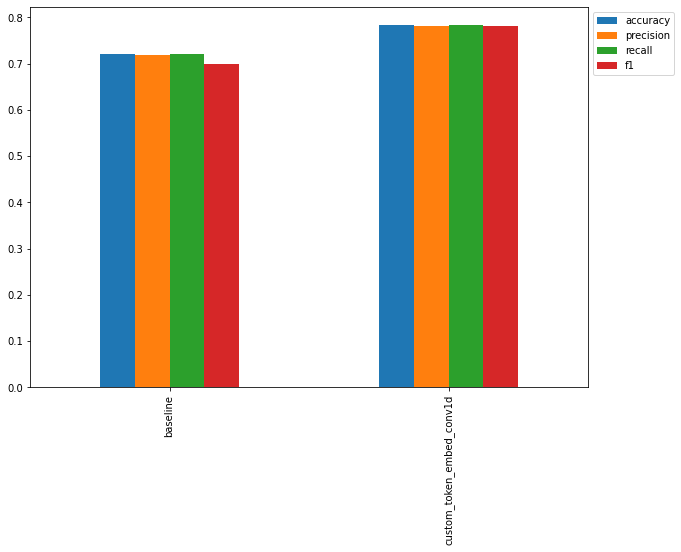

In [53]:
# Compare the model with baseline results

# Combine model results into a DataFrame
m1_baseline = pd.DataFrame({"baseline": baseline_results,
                            "custom_token_embed_conv1d": m1_results,
                                  })
# Transpose by label
m1_baseline= m1_baseline.transpose()
m1_baseline["accuracy"] = m1_baseline["accuracy"]/100 # Fix the accuracy

m1_baseline.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

As we can see, the custom token_embed_conv1d_ model outperforms our baseline model by a small margin, let us see whether it can do better with a combined hybrid model of character and word layer tokenization

## Model 2 : Combining pretrained token embeddings + characters embeddings (hybrid embed layer)

1. Create a token level embedding model like `model_1`
2. Create a character level model like `model_3` with slight modification
3. Combine 1 & 2 with `layers.Concatenate`
4. Build a series of output layers on 3. 
5. Construct a model which takes token and character level sequences as inputs and produces sequence label probabilities as outputs

### Creating the pretrained token embeddings

Since we're moving towards replicating the model architecture in <a href="https://arxiv.org/pdf/1612.05251.pdf">Neural Networks for Joint Sentence Classification in Medical Paper Abstracts</a>, it mentions they used a <a href="https://nlp.stanford.edu/projects/glove/">pretrained GloVe embedding</a> as a way to initialise their token embeddings.


```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder)
-> Layers -> Output (prediction probabilities)
```
We'll keep the pretrained embeddings frozen (by setting trainable=False) and add a trainable couple of layers on the top to tailor the model outputs to our own data.

In [54]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable = False,
                                        name = "universal_sentence_encoder")

In [55]:
# test out the pretained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random Sentence:
 in patients with impaired glucose tolerance at high risk for cardiovascular events , the prevalence of venous thromboembolism was rare but associated with worse long-term cardiovascular outcomes , including arterial events .
Sentence after embedding:
[-0.00596683  0.07050405 -0.02217284 -0.00440182  0.0255595  -0.05458624
  0.05063177 -0.04065344  0.06469958  0.0022825   0.07954933 -0.01333946
  0.04784944 -0.00465907 -0.01772933 -0.04945191 -0.07957704  0.0251027
  0.03335484  0.02639471  0.03847705  0.01842383  0.02944371 -0.04418518
  0.06169699 -0.03657138 -0.0703308   0.03006945 -0.06953498 -0.03424601] (truncated output)...

Length of sentence embedding:
512


### Creating the character vectorizer layer

The paper we're replicating uses hybrid token and character embedding.

We can create a character-level embedding by first vectorizing our sequences (after they've been split into characters) using the `TextVectorization` class and then passing those vectorized sequences through an `Embedding layer`.

Before we can vectorize our sequences on a character-level we'll need to split them into characters. Let's write a function to do so.

Our current textvectorizer works on a word level. We need to first split our data into characters in order and then use it on characters

In [61]:
def splitter(data):
  return " ".join(list(data))

train_chars = [splitter(sentence) for sentence in train_sentences]
val_chars = [splitter(sentence) for sentence in val_sentences]
test_chars = [splitter(sentence) for sentence in test_sentences]

# check out the first five character seperated sentences
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [62]:
# Check out average length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [ ]:
# Check out the character distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins = 100);


In [63]:
# what character length covers 95% sentences?
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [64]:
# Get all keyboard characters
import string
alpha = string.ascii_lowercase + string.digits + string.punctuation
alpha , len(alpha) # Can be used for creating char vectors

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [65]:
# Create char-level token vectorizer instance
char_vectorizer = TextVectorization(max_tokens = len(alpha) + 2, # For UNK AND SPACE TOKEN
                                    output_sequence_length = output_seq_char_len,
                                    name = "char_vectorizer")

In [66]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [67]:
# testing the character vectorization
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
p r e v i o u s   s t u d i e s   h a v e   f o c u s e d   o n   p r o p h y l a x i s   i n   m i d d l e   e a r   s u r g e r y   a l o n e   w i t h o u t   i n c l u s i o n   o f   m a s t o i d e c t o m y   .

Length of chars: 94

Vectorized chars:
[[14  8  2 21  4  7 16  9  9  3 16 10  4  2  9 13  5 21  2 17  7 11 16  9
   2 10  7  6 14  8  7 14 13 19 12  5 24  4  9  4  6 15  4 10 10 12  2  2
   5  8  9 16  8 18  2  8 19  5 12  7  6  2 20  4  3 13  7 16  3  4  6 11
  12 16  9  4  7  6  7 17 15  5  9  3  7  4 10  2 11  3  7 15 19  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating the character embedding layer

In our to create our hybrid model we also need to create the character embedding layer after the character vectorizer just like the text embedding layer after the text vectorizer which was created earlier.

We will use 25 output dim just like the paper for out output vector and mask all the zeroes

In [68]:
char_embed = layers.Embedding(input_dim = 28, # total length in char_vectorizer = 26 + 2 (for UNK and "/space")
                              output_dim = 25,
                              mask_zero = True,
                              name = "char_embed")

In [69]:
# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p r e v i o u s   s t u d i e s   h a v e   f o c u s e d   o n   p r o p h y l a x i s   i n   m i d d l e   e a r   s u r g e r y   a l o n e   w i t h o u t   i n c l u s i o n   o f   m a s t o i d e c t o m y   .

Embedded chars (after vectorization and embedding):
[[[-0.03223468 -0.02980951 -0.04986485 ...  0.00389838 -0.00199177
   -0.02095783]
  [ 0.04262446  0.02685023 -0.03411337 ...  0.04522467 -0.01009031
    0.02774758]
  [ 0.01331845 -0.04641032  0.0367786  ... -0.01117102  0.04596816
    0.01238718]
  ...
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]
  [-0.00644445  0.00248653 -0.00032532 ...  0.03155345  0.03697617
   -0.03122803]]]

Character embedding shape: (1, 290, 25)


### Creating the hybrid token + char embed layer

In [72]:
# setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)
                             

# setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
# check out the bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)
                           

# Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
                                                                  

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_2 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_2_token_and_char_embeddings")

In [73]:
model_2.summary()

Model: "model_2_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

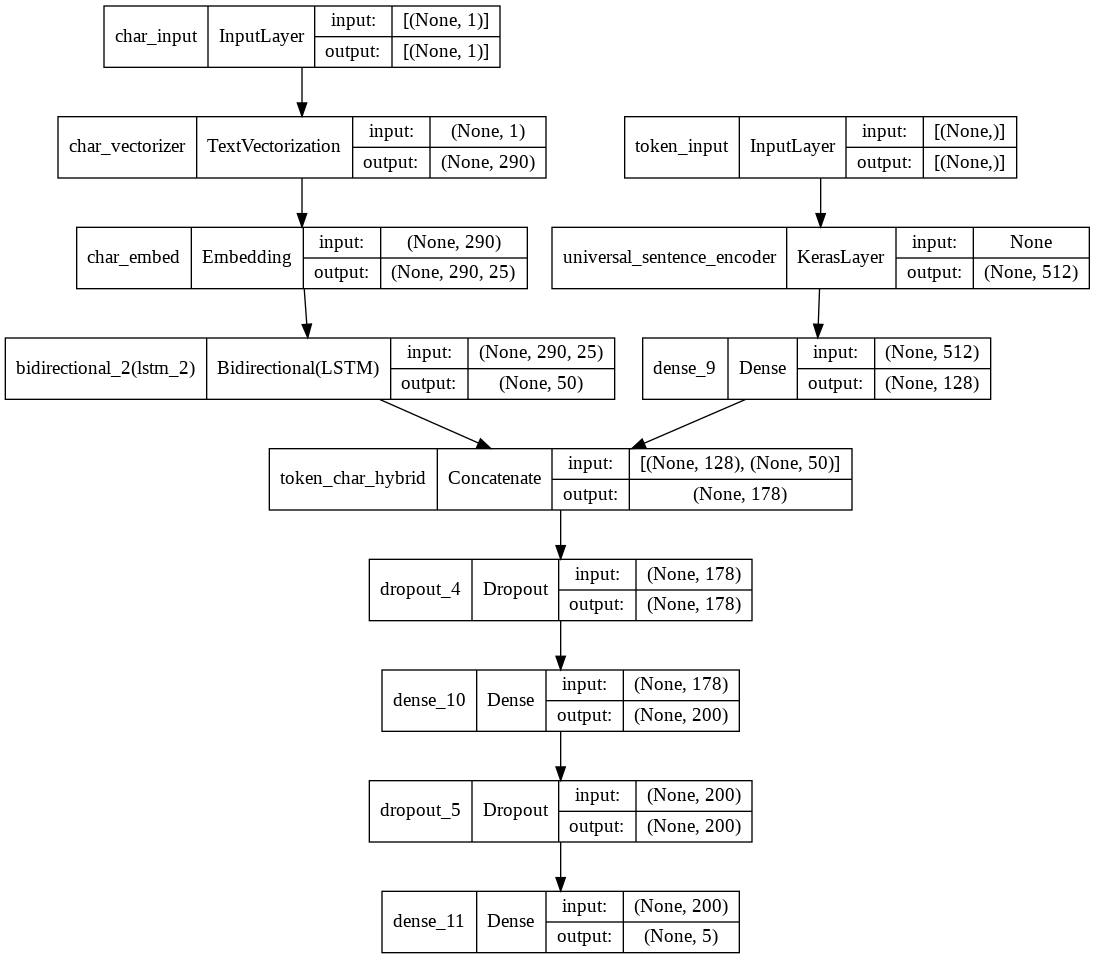

In [74]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes = True)

In [75]:
# Compile the token char model
model_2.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

### Fitting the model

In order to fit our model we need to create input datasets of combined text and char layers into a `tf.data.Dataset`

We can do this by create a `tf.data.Dataset` with a tuple as it's first input, for example:

`((token_data, char_data), (label))`

In [78]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [80]:
# Fit the model on tokens and chars
model_2_history = model_2.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 88s 136ms/step - loss: 0.9735 - accuracy: 0.6155 - val_loss: 0.7869 - val_accuracy: 0.6925
Epoch 2/3
562/562 [==============================] - 73s 130ms/step - loss: 0.7970 - accuracy: 0.6919 - val_loss: 0.7178 - val_accuracy: 0.7267
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.7716 - accuracy: 0.7036 - val_loss: 0.6881 - val_accuracy: 0.7404


### Evaluating our model

In [81]:
model_2.evaluate(val_char_token_dataset)

945/945 [==============================] - 51s 54ms/step - loss: 0.6971 - accuracy: 0.7350


[0.6970729231834412, 0.7349728345870972]

In [84]:
# Make predictions using the token-character model hybrid
m2_probs = model_2.predict(val_char_token_dataset)
# Turn prediction probabilities into prediction classes
m2_preds = tf.argmax(m2_probs, axis=1)
# Get results of token-char-hybrid model
m2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=m2_preds)
m2_results

{'accuracy': 73.49728584668344,
 'f1': 0.7327265232825272,
 'precision': 0.7373433060133987,
 'recall': 0.7349728584668344}

### Comparing the model results so far ...

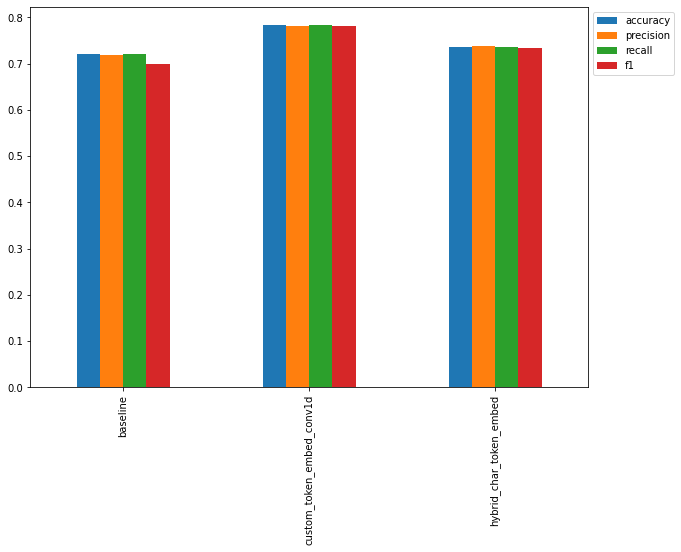

In [108]:
# Compare the model with baseline results and model_1 results

# Combine model results into a DataFrame
m2_m1_baseline = pd.DataFrame({"baseline": baseline_results,
                               "custom_token_embed_conv1d": m1_results,                                
                               "hybrid_char_token_embed": m2_results
                               })
                                  
# Transpose by label
m2_m1_baseline= m2_m1_baseline.transpose()
m2_m1_baseline["accuracy"] = m2_m1_baseline["accuracy"]/100 # Fix the accuracy

m2_m1_baseline.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

So our model doesn't improve by adding the character tokens. We shall now look forward to creating a tribrid model with positional embeddings instead in hope of improving it.



## Model 3: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

We shall now improvise upon model_2 by adding the positional features of `line_number` and `total_lines` in our model.


before doing that, we need to create positional embeddings of our own...

### Creating Positional Embeddings 

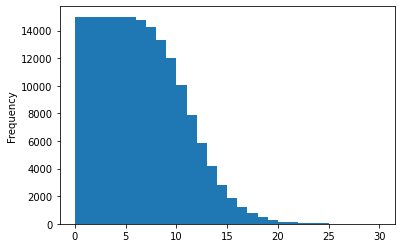

In [82]:
# plotting the different kind of line numbers available
train_df["line_number"].plot(kind="hist" , bins = 30)

In [86]:
# one hot encoding the line number column
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth = 15)

train_line_numbers_one_hot[:14] ,train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

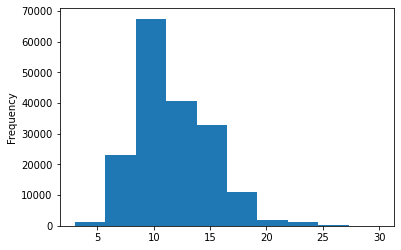

In [87]:
# check the distributions of total lines
train_df.total_lines.plot.hist()

In [89]:
# size of total_lines in top 98%ile
np.percentile(train_df.total_lines, 98)

20.0

In [91]:
# onehot encoding of total_lines

train_total_lines_one_hot = tf.one_hot(train_df.total_lines.to_numpy(), depth = 20) # depth here decides how much values per array onehot label
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.to_numpy(), depth = 20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token level model
2. Create a char level model
3. Create a model for  the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combined the outputs of 1 & 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3,4,5 using tf.`keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and produce output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a `tf.keras.Model`

In [95]:
# 1. Token inputs

token_inputs = layers.Input(shape = [], dtype = tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape = (1,), dtype = tf.string,name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. line_number model
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name="line_number_input")
x = layers.Dense(32, activation = "relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs =x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32 , name="total_lines_input")
y = layers.Dense(32, activation = "relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name = "char_token_hybrid_embed")([token_model.output,
                                                                            char_model.output])
z = layers.Dense(256, activation = "relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedddings with combined total and char embeddings

tribrid_embeddings = layers.Concatenate(name = "tribrid_embed")([line_number_model.output,
                                                                 total_lines_model.output,
                                                                 z])

# 7. Create output layer 
output_layer = layers.Dense(5, activation = "softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_3 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer,
                         name = "tribrid_model_3")


In [97]:
model_3.summary()

Model: "tribrid_model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0

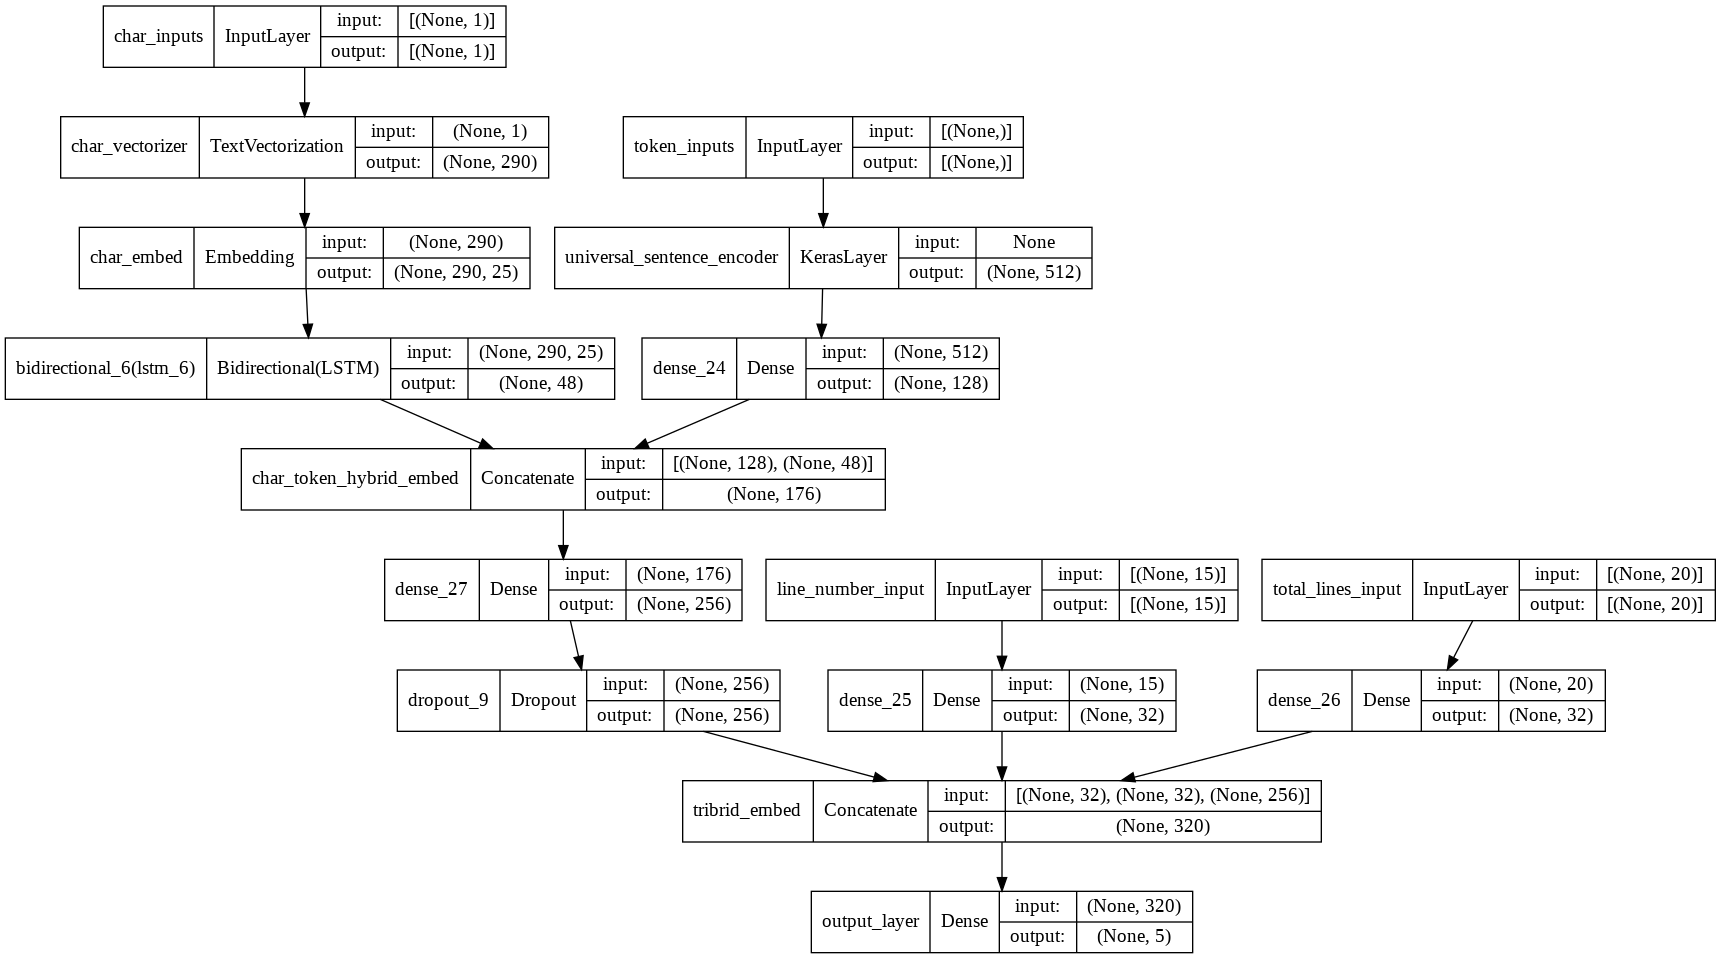

In [99]:
plot_model(model_3, show_shapes = True)

In [101]:
# Compile token, char, positional embedding model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

If the prediction probability of a model on a single class is extremely high then it may be overfitting and not being able to consider other classes.

Really Confident : `[0.0,0.0,1.0,0.0,0.0]`

What `label smoothing` does is to assign some of the value from the highest pred prob to other classes in turn of improving generalization

`[0.01,0.01,0.96,0.01,0.01]`

### Create Tribrid embedding datasets using tf.data

Just like our hybrid model, we have to create input datasets for our tribrid models too. Furthermore, we have to prefetch and batch them in advance to improve our computational speed.

In the end they will look like this:

```
(((None, 15), (None, 20), (None,), (None,)), (None, 5))
```

In [102]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

### Fitting our tribrid model and evaluating it

Now that everything has been done, we can fit the model and then evaluate results

In [103]:
# Fit the token, char and positional embedding model
history_model_3 = model_3.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 84s 133ms/step - loss: 1.0973 - accuracy: 0.7224 - val_loss: 0.9843 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 71s 127ms/step - loss: 0.9657 - accuracy: 0.8174 - val_loss: 0.9491 - val_accuracy: 0.8278
Epoch 3/3
562/562 [==============================] - 68s 121ms/step - loss: 0.9501 - accuracy: 0.8235 - val_loss: 0.9403 - val_accuracy: 0.8318


In [104]:
m3_probs = model_3.predict(val_pos_char_token_dataset, verbose=1)
# Turn prediction probabilities into prediction classes
m3_preds = tf.argmax(m3_probs, axis=1)
# Calculate results of token-char-positional hybrid model
m3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=m3_preds)
m3_results

945/945 [==============================] - 51s 50ms/step


{'accuracy': 83.09612074672316,
 'f1': 0.8299086914794448,
 'precision': 0.8296517445599948,
 'recall': 0.8309612074672316}

### Comparing the model results so far ...

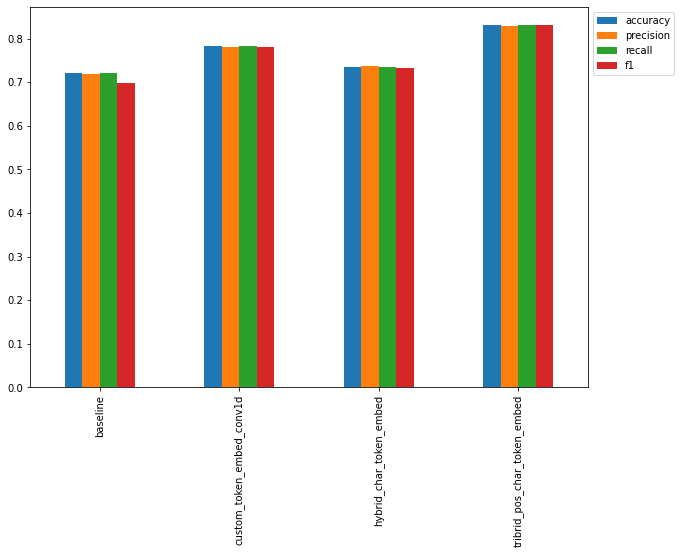

In [105]:
# Compare the model with baseline results and model_1 results

# Combine model results into a DataFrame
m3_m2_m1_baseline = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": m1_results,                                
                                  "hybrid_char_token_embed": m2_results,
                                  "tribrid_pos_char_token_embed": m3_results
                               })
                                  
# Transpose by label
m3_m2_m1_baseline= m3_m2_m1_baseline.transpose()
m3_m2_m1_baseline["accuracy"] = m3_m2_m1_baseline["accuracy"]/100 # Fix the accuracy

m3_m2_m1_baseline.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

Our tribrid model does wonderful this time we have achieved an accuracy of **83.09%** which is greater than the baseline accuracy of **72.18%** which we wanted to beat by **10.91%**
